# Image classification

In [16]:
import torch
from torch import Generator

# Set the random seed for reproducibility
random_state = 42

In [17]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Preprocessing

In [18]:
import os
from data import train_val_split

base_dir = './data/train'
train_dir = './data/preprocessed/train'
val_dir = './data/preprocessed/val'

val_ratio = 0.2

if not os.path.exists(train_dir) and not os.path.exists(val_dir):
    train_val_split(base_dir, train_dir, val_dir, val_ratio, random_state) 

    print("Saved train data to:", train_dir)
    print("Saved validation data to:", val_dir)
else:
    print("Train and validation directories already exist.")

Train and validation directories already exist.


## Data

### Augmentation

In [19]:
import torchvision.transforms as transforms

mean_tensor = torch.tensor([0.5, 0.5, 0.5])
std_tensor = torch.tensor([0.5, 0.5, 0.5])

# mean_tensor = torch.tensor([0.5209, 0.4955, 0.4384])
# std_tensor = torch.tensor([0.2111, 0.2103, 0.2101])

default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

### Datasets and sampling

In [20]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from data import sample_dataset

train_default_ds = ImageFolder(train_dir, transform=default_transform)
train_augmented_ds = ImageFolder(train_dir, transform=augmented_transform)
train_ds = ConcatDataset([train_default_ds, train_augmented_ds])

val_ds = ImageFolder(val_dir, transform=default_transform)

# downsample the dataset
sample_ratio = 1
sampled_train_ds = sample_dataset(train_ds, sample_ratio, seed=random_state)
sampled_val_ds = sample_dataset(val_ds, sample_ratio, seed=random_state)

num_classes = len(train_default_ds.classes)

print(f"Number of training samples: {len(sampled_train_ds)}")
print(f"Number of validation samples: {len(sampled_val_ds)}")

Number of training samples: 140818
Number of validation samples: 17602


In [21]:
# from plots import plot_class_distribution

# plot_class_distribution(sampled_train_ds)

### Data loaders

In [26]:
batch_size = 256
num_workers = 0

# setup data loaders
train_dl = DataLoader(sampled_train_ds,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      generator=Generator().manual_seed(random_state))

val_dl = DataLoader(sampled_val_ds,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=False)

### Example

Sample image shape: torch.Size([3, 64, 64])
Sample label: 0


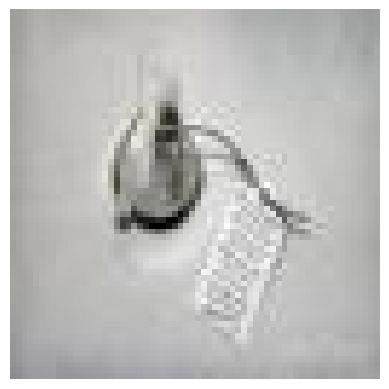

In [23]:
from utils import show_image

sample_img, sample_label = train_ds[0]

print(f"Sample image shape: {sample_img.size()}")
print(f"Sample label: {sample_label}")

show_image(sample_img)

## Training

In [24]:
from training import Trainer
import torch.optim as optim

### BasicModel

In [10]:
from models import BasicNet

basicNet = BasicNet(num_classes=num_classes)

optimizer = optim.AdamW(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

Epoch 1/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 1/20: Train Loss: 3.8354, Val Loss: 3.6940, Avg Class Accuracy: 0.0769


Epoch 2/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch 2/20: Train Loss: 3.5811, Val Loss: 3.3599, Avg Class Accuracy: 0.1300


Epoch 3/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch 3/20: Train Loss: 3.4320, Val Loss: 3.2043, Avg Class Accuracy: 0.1515


Epoch 4/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Epoch 4/20: Train Loss: 3.3193, Val Loss: 3.1242, Avg Class Accuracy: 0.1950


Epoch 5/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch 5/20: Train Loss: 3.2187, Val Loss: 3.0076, Avg Class Accuracy: 0.2057


Epoch 6/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epoch 6/20: Train Loss: 3.1299, Val Loss: 2.8990, Avg Class Accuracy: 0.2498


Epoch 7/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Epoch 7/20: Train Loss: 3.0629, Val Loss: 2.8780, Avg Class Accuracy: 0.2563


Epoch 8/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 8/20: Train Loss: 2.9860, Val Loss: 2.8073, Avg Class Accuracy: 0.2691


Epoch 9/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Epoch 9/20: Train Loss: 2.9233, Val Loss: 2.7752, Avg Class Accuracy: 0.2676


Epoch 10/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Epoch 10/20: Train Loss: 2.8682, Val Loss: 2.7093, Avg Class Accuracy: 0.2840


Epoch 11/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch 11/20: Train Loss: 2.8165, Val Loss: 2.6399, Avg Class Accuracy: 0.2865


Epoch 12/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Epoch 12/20: Train Loss: 2.7481, Val Loss: 2.5963, Avg Class Accuracy: 0.2978


Epoch 13/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Epoch 13/20: Train Loss: 2.6967, Val Loss: 2.5657, Avg Class Accuracy: 0.3158


Epoch 14/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Epoch 14/20: Train Loss: 2.6512, Val Loss: 2.5418, Avg Class Accuracy: 0.3106


Epoch 15/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch 15/20: Train Loss: 2.6086, Val Loss: 2.4970, Avg Class Accuracy: 0.3209


Epoch 16/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Epoch 16/20: Train Loss: 2.5816, Val Loss: 2.4758, Avg Class Accuracy: 0.3291


Epoch 17/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch 17/20: Train Loss: 2.5344, Val Loss: 2.4542, Avg Class Accuracy: 0.3409


Epoch 18/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Epoch 18/20: Train Loss: 2.5081, Val Loss: 2.4027, Avg Class Accuracy: 0.3378


Epoch 19/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch 19/20: Train Loss: 2.4579, Val Loss: 2.3929, Avg Class Accuracy: 0.3376


Epoch 20/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

Epoch 20/20: Train Loss: 2.4334, Val Loss: 2.3557, Avg Class Accuracy: 0.3519


### Basic ResNet

In [27]:
from models import BasicResNet

basicResNet = BasicResNet(num_classes=num_classes)

optimizer = optim.AdamW(basicResNet.to(device).parameters(), lr=1e-4, weight_decay=1e-4)

trainer = Trainer(basicResNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=50)

# simplier arch 0.3616

Epoch 1/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 1/50: Train Loss: 2.8239, Val Loss: 2.4377, Avg Class Accuracy: 0.3323


Epoch 2/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 2/50: Train Loss: 2.2333, Val Loss: 2.2033, Avg Class Accuracy: 0.4042


Epoch 3/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 3/50: Train Loss: 1.9612, Val Loss: 1.9874, Avg Class Accuracy: 0.4531


Epoch 4/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 4/50: Train Loss: 1.7686, Val Loss: 1.7886, Avg Class Accuracy: 0.5068


Epoch 5/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 5/50: Train Loss: 1.6128, Val Loss: 1.7283, Avg Class Accuracy: 0.5146


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 6/50: Train Loss: 1.4916, Val Loss: 1.5974, Avg Class Accuracy: 0.5515


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 7/50: Train Loss: 1.3862, Val Loss: 1.5549, Avg Class Accuracy: 0.5608


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 8/50: Train Loss: 1.2940, Val Loss: 1.5526, Avg Class Accuracy: 0.5663


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


Epoch 9/50: Train Loss: 1.2144, Val Loss: 1.5295, Avg Class Accuracy: 0.5766


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


Epoch 10/50: Train Loss: 1.1474, Val Loss: 1.4671, Avg Class Accuracy: 0.5932


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 11/50: Train Loss: 1.0796, Val Loss: 1.5496, Avg Class Accuracy: 0.5773


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 12/50: Train Loss: 1.0202, Val Loss: 1.4111, Avg Class Accuracy: 0.6100


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 13/50: Train Loss: 0.9655, Val Loss: 1.5639, Avg Class Accuracy: 0.5865


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 14/50: Train Loss: 0.9126, Val Loss: 1.4164, Avg Class Accuracy: 0.6180


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 15/50: Train Loss: 0.8664, Val Loss: 1.4535, Avg Class Accuracy: 0.6087


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 16/50: Train Loss: 0.8228, Val Loss: 1.4319, Avg Class Accuracy: 0.6168


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 17/50: Train Loss: 0.7864, Val Loss: 1.5126, Avg Class Accuracy: 0.6043


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 18/50: Train Loss: 0.7429, Val Loss: 1.3737, Avg Class Accuracy: 0.6274


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 19/50: Train Loss: 0.7041, Val Loss: 1.4430, Avg Class Accuracy: 0.6181


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 20/50: Train Loss: 0.6761, Val Loss: 1.4727, Avg Class Accuracy: 0.6206


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 21/50: Train Loss: 0.6541, Val Loss: 1.4759, Avg Class Accuracy: 0.6231


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 22/50: Train Loss: 0.6196, Val Loss: 1.5446, Avg Class Accuracy: 0.6250


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 23/50: Train Loss: 0.5927, Val Loss: 1.4938, Avg Class Accuracy: 0.6322


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 24/50: Train Loss: 0.5705, Val Loss: 1.4914, Avg Class Accuracy: 0.6292


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 25/50: Train Loss: 0.5483, Val Loss: 1.4775, Avg Class Accuracy: 0.6349


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 26/50: Train Loss: 0.5313, Val Loss: 1.5059, Avg Class Accuracy: 0.6340


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.66it/s]


Epoch 27/50: Train Loss: 0.5126, Val Loss: 1.4565, Avg Class Accuracy: 0.6397


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 28/50: Train Loss: 0.4967, Val Loss: 1.4610, Avg Class Accuracy: 0.6385


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 29/50: Train Loss: 0.4802, Val Loss: 1.4760, Avg Class Accuracy: 0.6409


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.76it/s]


Epoch 30/50: Train Loss: 0.4643, Val Loss: 1.4632, Avg Class Accuracy: 0.6415


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 31/50: Train Loss: 0.4568, Val Loss: 1.4802, Avg Class Accuracy: 0.6439


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 32/50: Train Loss: 0.4381, Val Loss: 1.5263, Avg Class Accuracy: 0.6407


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 33/50: Train Loss: 0.4255, Val Loss: 1.4726, Avg Class Accuracy: 0.6472


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 34/50: Train Loss: 0.4128, Val Loss: 1.5213, Avg Class Accuracy: 0.6498


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 35/50: Train Loss: 0.3994, Val Loss: 1.5918, Avg Class Accuracy: 0.6447


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 36/50: Train Loss: 0.3923, Val Loss: 1.5485, Avg Class Accuracy: 0.6440


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 37/50: Train Loss: 0.3788, Val Loss: 1.5804, Avg Class Accuracy: 0.6405


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 38/50: Train Loss: 0.3743, Val Loss: 1.5534, Avg Class Accuracy: 0.6469


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 39/50: Train Loss: 0.3599, Val Loss: 1.5862, Avg Class Accuracy: 0.6481


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 40/50: Train Loss: 0.3537, Val Loss: 1.5596, Avg Class Accuracy: 0.6423


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 41/50: Train Loss: 0.3458, Val Loss: 1.6147, Avg Class Accuracy: 0.6420


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.29it/s]


Epoch 42/50: Train Loss: 0.3357, Val Loss: 1.5304, Avg Class Accuracy: 0.6478


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 43/50: Train Loss: 0.3327, Val Loss: 1.5647, Avg Class Accuracy: 0.6562


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 44/50: Train Loss: 0.3208, Val Loss: 1.5456, Avg Class Accuracy: 0.6512


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Epoch 45/50: Train Loss: 0.3155, Val Loss: 1.5821, Avg Class Accuracy: 0.6459


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.30it/s]


Epoch 46/50: Train Loss: 0.3118, Val Loss: 1.6188, Avg Class Accuracy: 0.6486


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 47/50: Train Loss: 0.3028, Val Loss: 1.5328, Avg Class Accuracy: 0.6611


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 48/50: Train Loss: 0.2979, Val Loss: 1.6162, Avg Class Accuracy: 0.6487


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.14it/s]


Epoch 49/50: Train Loss: 0.2882, Val Loss: 1.5942, Avg Class Accuracy: 0.6505


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:22<00:00,  3.12it/s]

Epoch 50/50: Train Loss: 0.2801, Val Loss: 1.6138, Avg Class Accuracy: 0.6516


### Four-block CNN

In [9]:
from models import FourBlockCNN

fourBlockCNN = FourBlockCNN(num_classes=50)

optimizer = optim.Adam(fourBlockCNN.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(fourBlockCNN, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

# Results:
# Without augmentation: Epoch 10/10: Train Loss: 2.2281, Val Loss: 2.4054, Avg Class Accuracy: 0.3387
# With augmentation: Epoch 10/10: Train Loss: 1.7477, Val Loss: 1.8611, Avg Class Accuracy: 0.4847

Epoch 1/20 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.10it/s]


Epoch 1/20: Train Loss: 3.3024, Val Loss: 3.5733, Avg Class Accuracy: 0.1213


Epoch 2/20 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.92it/s]


Epoch 2/20: Train Loss: 2.7460, Val Loss: 3.4901, Avg Class Accuracy: 0.1737


Epoch 3/20 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.91it/s]


Epoch 3/20: Train Loss: 2.4540, Val Loss: 2.9737, Avg Class Accuracy: 0.2378


Epoch 4/20 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.85it/s]


Epoch 4/20: Train Loss: 2.2556, Val Loss: 2.8185, Avg Class Accuracy: 0.2789


Epoch 5/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.80it/s]


Epoch 5/20: Train Loss: 2.1076, Val Loss: 2.7340, Avg Class Accuracy: 0.2892


Epoch 6/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 6/20: Train Loss: 1.9881, Val Loss: 2.6600, Avg Class Accuracy: 0.3135


Epoch 7/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 7/20: Train Loss: 1.8871, Val Loss: 2.5154, Avg Class Accuracy: 0.3494


Epoch 8/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 8/20: Train Loss: 1.7981, Val Loss: 2.3087, Avg Class Accuracy: 0.3861


Epoch 9/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 9/20: Train Loss: 1.7298, Val Loss: 2.1465, Avg Class Accuracy: 0.4234


Epoch 10/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 10/20: Train Loss: 1.6585, Val Loss: 2.0331, Avg Class Accuracy: 0.4497


Epoch 11/20 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 11/20: Train Loss: 1.5961, Val Loss: 1.9840, Avg Class Accuracy: 0.4616


Epoch 12/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 12/20: Train Loss: 1.5370, Val Loss: 1.9631, Avg Class Accuracy: 0.4698


Epoch 13/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.66it/s]


Epoch 13/20: Train Loss: 1.4848, Val Loss: 1.8858, Avg Class Accuracy: 0.4844


Epoch 14/20 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 14/20: Train Loss: 1.4421, Val Loss: 1.8203, Avg Class Accuracy: 0.5091


Epoch 15/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 15/20: Train Loss: 1.3988, Val Loss: 1.8170, Avg Class Accuracy: 0.5063


Epoch 16/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 16/20: Train Loss: 1.3530, Val Loss: 1.7241, Avg Class Accuracy: 0.5261


Epoch 17/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 17/20: Train Loss: 1.3146, Val Loss: 1.7582, Avg Class Accuracy: 0.5270


Epoch 18/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 18/20: Train Loss: 1.2846, Val Loss: 1.6729, Avg Class Accuracy: 0.5446


Epoch 19/20 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 19/20: Train Loss: 1.2455, Val Loss: 1.5932, Avg Class Accuracy: 0.5629


Epoch 20/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.66it/s]

Epoch 20/20: Train Loss: 1.2140, Val Loss: 1.6710, Avg Class Accuracy: 0.5481


## Resnet18

Here we train the ResNet18 model on the dataset to see the state of the art performance.

In [10]:
import torch.nn as nn

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)

resnet18 = resnet18.to(device)

optimizer = optim.Adam(resnet18.parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(resnet18, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

Using cache found in /Users/grzegorzstatkiewicz/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.50it/s]


Epoch 1/20: Train Loss: 2.7824, Val Loss: 2.4378, Avg Class Accuracy: 0.3320


Epoch 2/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.38it/s]


Epoch 2/20: Train Loss: 2.1387, Val Loss: 2.1194, Avg Class Accuracy: 0.4181


Epoch 3/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.34it/s]


Epoch 3/20: Train Loss: 1.8145, Val Loss: 2.0159, Avg Class Accuracy: 0.4526


Epoch 4/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.37it/s]


Epoch 4/20: Train Loss: 1.5512, Val Loss: 1.9710, Avg Class Accuracy: 0.4640


Epoch 5/20 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.31it/s]


Epoch 5/20: Train Loss: 1.3172, Val Loss: 1.9486, Avg Class Accuracy: 0.4789


Epoch 6/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.32it/s]


Epoch 6/20: Train Loss: 1.1019, Val Loss: 1.9828, Avg Class Accuracy: 0.4856


Epoch 7/20 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.31it/s]


Epoch 7/20: Train Loss: 0.9306, Val Loss: 2.0348, Avg Class Accuracy: 0.4912


Epoch 8/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.45it/s]


Epoch 8/20: Train Loss: 0.7978, Val Loss: 2.1219, Avg Class Accuracy: 0.4962


Epoch 9/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.42it/s]


Epoch 9/20: Train Loss: 0.7041, Val Loss: 2.1299, Avg Class Accuracy: 0.4963


Epoch 10/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.39it/s]


Epoch 10/20: Train Loss: 0.6226, Val Loss: 2.1874, Avg Class Accuracy: 0.4970


Epoch 11/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.38it/s]


Epoch 11/20: Train Loss: 0.5756, Val Loss: 2.2226, Avg Class Accuracy: 0.4987


Epoch 12/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.39it/s]


Epoch 12/20: Train Loss: 0.5304, Val Loss: 2.2860, Avg Class Accuracy: 0.4952


Epoch 13/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.41it/s]


Epoch 13/20: Train Loss: 0.4914, Val Loss: 2.2734, Avg Class Accuracy: 0.5028


Epoch 14/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.41it/s]


Epoch 14/20: Train Loss: 0.4575, Val Loss: 2.2841, Avg Class Accuracy: 0.5050


Epoch 15/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.35it/s]


Epoch 15/20: Train Loss: 0.4213, Val Loss: 2.3178, Avg Class Accuracy: 0.5096


Epoch 16/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.40it/s]


Epoch 16/20: Train Loss: 0.3918, Val Loss: 2.3276, Avg Class Accuracy: 0.5065


Epoch 17/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.37it/s]


Epoch 17/20: Train Loss: 0.3736, Val Loss: 2.3495, Avg Class Accuracy: 0.5092


Epoch 18/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.40it/s]


Epoch 18/20: Train Loss: 0.3491, Val Loss: 2.4328, Avg Class Accuracy: 0.5094


Epoch 19/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.39it/s]


Epoch 19/20: Train Loss: 0.3224, Val Loss: 2.4313, Avg Class Accuracy: 0.5070


Epoch 20/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.38it/s]

Epoch 20/20: Train Loss: 0.3031, Val Loss: 2.4299, Avg Class Accuracy: 0.5105


## Save models

In [11]:
torch.save(basicNet.state_dict(), "./models/basicNet.pth")

In [12]:
torch.save(fourBlockCNN.state_dict(), "./models/fourBlockCNN.pth")

In [13]:
torch.save(resnet18.state_dict(), "./models/resnet18.pth")

In [28]:
torch.save(basicResNet.state_dict(), "./models/basicResNet.pth")